In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import node2vecs
import lfr
import cProfile
import networkx as nx
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import geoopt
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import importlib
importlib.reload(node2vecs)

<module 'node2vecs' from '/nfs/nfs9/home/nobackup/gogandhi/alt_means_sans_k/libs/node2vec/node2vecs/__init__.py'>

In [3]:

def create_network(params={
    "N": 1000,     # number of nodes
    "k": 5,        # average degree
    "maxk": 50,    # maximum degree
    "minc": 25,    # minimum community size
    "maxc": 250,   # maximum community size
    "tau": 2.1,      # degree exponent
    "tau2": 1.6,   # community size exponent
    "mu": 0.1,     # mixing rate
}):
    ng = lfr.NetworkGenerator()
    data = ng.generate(**params)
    net = data["net"]                  # scipy.csr_sparse matrix
    community_table = data["community_table"]  # pandas DataFrame
    seed = data["seed"]                # Seed value
    return net, community_table, seed


# Create a sample graph (Karate Club)

#G = nx.karate_club_graph() # Try this for faster analysis
N = 10000
params= {"N": N,
    "k": 50,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.1}


A, community_labels, _ = create_network()
G = nx.from_scipy_sparse_array(A)

In [4]:
community_labels

,node_id,community_id
0,0,7
1,1,7
2,2,6
3,3,2
4,4,9
...,...,...
995,995,8
996,996,6
997,997,1
998,998,6


In [5]:
profiler = cProfile.Profile()
profiler.enable()
#-----------------------

num_walks = 10
walk_length = 80
window_size = 10
embedding_dim = 64
negative_samples = 5
num_epochs = 3
sim_type = "cosine"

# Params of node2vecs.TorchNode2Vec(__)
# batch_size=256,
# device="cpu",
# buffer_size=100000,
# context_window_type="double",
# miniters=200,
# num_workers=1,
# alpha=1e-3,
# learn_outvec=True,
# similarity_metric='dot',

#from node2vecs import TorchNode2Vec

similarity_measures = ["dot","euclidean","cosine"]
embeddings = {}
embedding_dim = 64

for sim in similarity_measures:
    print(f"Training model using {sim} similarity...")
    model = node2vecs.TorchNode2Vec(vector_size=embedding_dim, similarity_metric=sim, device = 'cuda:1',num_workers=1)
    model.fit(A)
    embeddings[sim] = model.transform()
    
# Now embeddings["dot"], embeddings["cosine"], and embeddings["euclidean"]
# contain the respective node embeddings.



#-----------------------
profiler.disable()

Training model using dot similarity...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:38<00:00, 81.79it/s, loss=0.912]


Training model using euclidean similarity...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.65it/s, loss=1.25]


Training model using cosine similarity...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:40<00:00, 76.44it/s, loss=1.25]


In [6]:
profiler.print_stats()

         22469033 function calls (21840001 primitive calls) in 127.369 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 820604845.py:10(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:11(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:26(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:27(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:28(<module>)
        1    0.000    0.000  127.375  127.375 820604845.py:30(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:42(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:5(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:6(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:7(<module>)
        1    0.000    0.000    0.000    0.000 820604845.py:8(<module>)
        1    0.000    0.000   

Moment of truth, does cosine have the norm =1 condition satisfied?

In [7]:
(embeddings['euclidean'].shape)

(1000, 64)

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

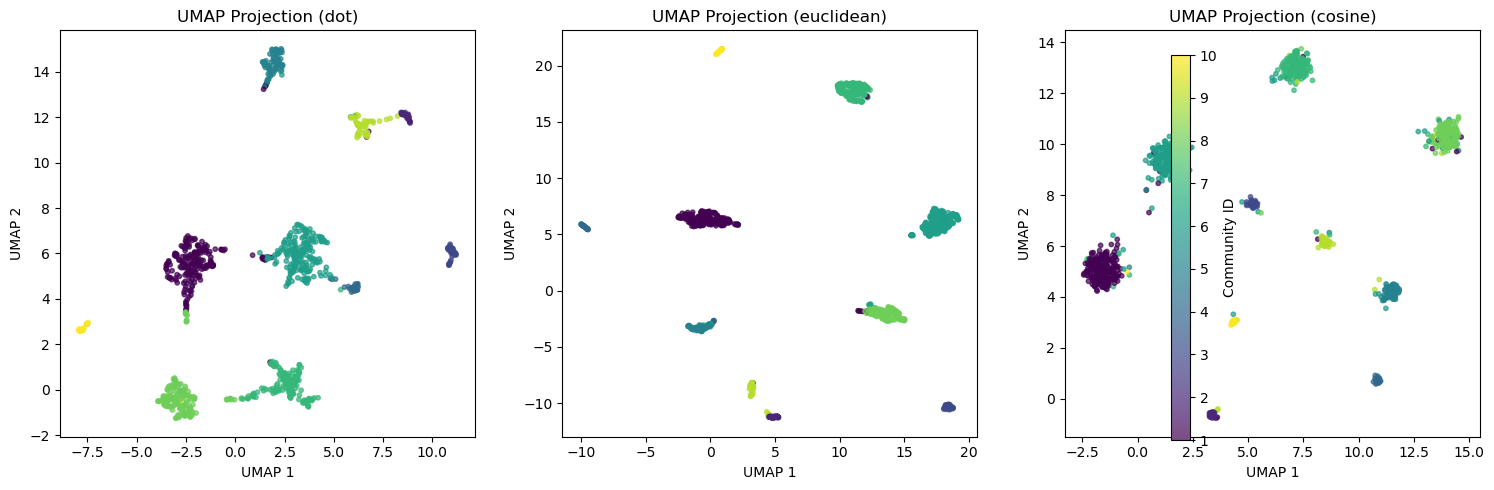

In [8]:
# Sort community_labels by node_id to ensure alignment with embedding order
community_labels_sorted = community_labels.sort_values('node_id')
# Extract community ids and (optionally) convert them to a colormap-friendly format
community_ids = community_labels_sorted['community_id'].values

# Create a UMAP reducer (you can adjust parameters as needed)
reducer = umap.UMAP(n_components=2, random_state=42)

# Set up a figure with one subplot per embedding type
fig, axes = plt.subplots(1, len(embeddings), figsize=(5 * len(embeddings), 5))

# In case there's only one embedding type, make sure axes is iterable
if len(embeddings) == 1:
    axes = [axes]

for ax, (sim_type, emb) in zip(axes, embeddings.items()):
    # Reduce high-dimensional embedding to 2D
    emb_2d = reducer.fit_transform(emb)
    # Scatter plot with community coloring (using a colormap, e.g., 'viridis')
    sc = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], c=community_ids, cmap='viridis', s=10, alpha=0.7)
    ax.set_title(f"UMAP Projection ({sim_type})")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

# If desired, add a colorbar. Note: if community IDs are categorical, you might prefer a discrete color mapping.
fig.colorbar(sc, ax=axes, label='Community ID')
plt.tight_layout()
plt.show()

In [8]:

def calculate_normalized_embedding_loss(V_a, V_b):
    def center_embeddings(V):
        # Subtract the mean of each column from the corresponding entries
        return V - np.mean(V, axis=0)

    
    # Step 1: Center both embedding matrices
    V_a_centered = center_embeddings(V_a)
    V_b_centered = center_embeddings(V_b)
    
    # Step 2: Calculate cosine similarity matrices for centered embeddings
    C_a = cosine_similarity(V_a_centered)
    C_b = cosine_similarity(V_b_centered)
    
    # Step 3: Calculate the absolute differences between cosine similarities
    N = V_a.shape[0]
    loss = 0
    
    # Only sum over the upper triangular part of the matrix (i < j)
    for i in range(N):
        for j in range(i+1, N):
            loss += np.abs(C_a[i, j] - C_b[i, j])
    
    # Step 4: Normalize the loss
    normalized_loss = (2 / (N * (N - 1))) * loss
    
    return normalized_loss
    

In [9]:
sim_keys = list(embeddings.keys())
n_keys = len(sim_keys)
loss_matrix = np.empty((n_keys, n_keys))
loss_matrix[:] = np.nan  # initialize all entries as NaN

# Compute the normalized embedding loss for each unique pair (upper triangle only)
for i in range(n_keys):
    for j in range(i + 1, n_keys):
        loss_value = calculate_normalized_embedding_loss(embeddings[sim_keys[i]], embeddings[sim_keys[j]])
        loss_matrix[i, j] = loss_value

# Create a DataFrame for nicer display
loss_df = pd.DataFrame(loss_matrix, index=sim_keys, columns=sim_keys)
print("Upper Triangle Matrix of Normalized Embedding Losses:")
print(loss_df)

Upper Triangle Matrix of Normalized Embedding Losses:
           dot  euclidean    cosine
dot        NaN   0.292847  0.185235
euclidean  NaN        NaN  0.376181
cosine     NaN        NaN       NaN


Upper Triangle Matrix of Normalized Embedding Losses:
           dot    cosine  euclidean
dot        NaN  0.136078   0.261833
cosine     NaN       NaN   0.172999
euclidean  NaN       NaN        NaN


In [10]:
# How similar is the dot embedding generated from this mod and embcom
import embcom
def create_embedding(G, emb_params = {
                                            "window_length": 10,
                                            "walk_length": 80,
                                            "num_walks": 10,
                                            "dim" : 64,
                                        }):
  
    model = embcom.embeddings.Node2Vec(window_length = emb_params['window_length'], walk_length=emb_params['walk_length'], num_walks=emb_params['num_walks'])
            
    net = nx.adjacency_matrix(G).astype(float)
    model.fit(net)
    emb = model.transform(dim=emb_params['dim'])

    return emb

emb_p =  create_embedding (G)


Ignore this message if you do not use Glove. Otherwise, install glove python package by 'pip install glove_python_binary' 


In [11]:
calculate_normalized_embedding_loss(emb_p, embeddings['dot']) # Loss seems pretty low!

0.10057194109776645